In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
def round_filters(filters, width_coefficient, width_divisor=8):
  if not width_coefficient:  
    return filters

  filters *= width_coefficient
  new_filters = max(width_divisor, int(filters+width_divisor/2) // width_divisor*width_divisor)
  # Make sure that round down does not go down by more than 10%.
  if new_filters < 0.9 * filters:
    new_filters += width_divisor
  return int(new_filters)

def round_repeats(repeats, depth_coefficient):
  if not depth_coefficient:
    return repeats

  return int(math.ceil(depth_coefficient * repeats))

def drop_connect(inputs, survival_prob, training):
  if not training:
    return inputs

  batch_size = inputs.shape[0]
  random_tensor = survival_prob
  random_tensor += torch.rand([batch_size, 1, 1, 1], device=inputs.device)
  binary_tensor = torch.floor(random_tensor)

  output = inputs / survival_prob * binary_tensor
  return output

In [ ]:
block_args = (
    {'expand_ratio' : 1, 'kernel_size' : 3, 'stride' : 1, 'in_channels' : 32, 'out_channels' : 16, 'repeats' : 1},
    {'expand_ratio' : 6, 'kernel_size' : 3, 'stride' : 2, 'in_channels' : 16, 'out_channels' : 24, 'repeats' : 2},
    {'expand_ratio' : 6, 'kernel_size' : 5, 'stride' : 2, 'in_channels' : 24, 'out_channels' : 40, 'repeats' : 2},
    {'expand_ratio' : 6, 'kernel_size' : 3, 'stride' : 2, 'in_channels' : 40, 'out_channels' : 80, 'repeats' : 3},
    {'expand_ratio' : 6, 'kernel_size' : 5, 'stride' : 1, 'in_channels' : 80, 'out_channels' : 112, 'repeats' : 3},
    {'expand_ratio' : 6, 'kernel_size' : 5, 'stride' : 2, 'in_channels' : 112, 'out_channels' : 192, 'repeats' : 4},
    {'expand_ratio' : 6, 'kernel_size' : 3, 'stride' : 1, 'in_channels' : 192, 'out_channels' : 320, 'repeats' : 1}
)

class SE(nn.Module):
  def __init__(self, in_channels, reduction=4):
    super().__init__()

    reduce_channels = max(1, in_channels // reduction)
    self.se = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(in_channels, reduce_channels, 1),
        nn.SiLU(),
        nn.Conv2d(reduce_channels, in_channels, 1),
        nn.Sigmoid()
    )

  def forward(self, inputs):
    out = self.se(inputs) * inputs
    return out
    

class MBConv(nn.Module):
  def __init__(self, 
               expansion_ratio, 
               in_channels, 
               out_channels, 
               kernel_size,
               bn_momentum,
               bn_epsilon,
               stride=1):
    
    super().__init__()

    expand_channels = in_channels*expansion_ratio
    self.residual = stride == 1 and in_channels == out_channels
    self.expansion_ratio = expansion_ratio

    self.expand_conv = nn.Sequential(
        nn.Conv2d(in_channels, expand_channels, 1, bias=False),
        nn.BatchNorm2d(expand_channels, bn_epsilon, bn_momentum),
        nn.SiLU()
    )

    padding = kernel_size // 2
    self.depthwise = nn.Sequential(
        nn.Conv2d(expand_channels, expand_channels, kernel_size, stride, padding, groups=expand_channels, bias=False),
        nn.BatchNorm2d(expand_channels, bn_epsilon, bn_momentum),
        nn.SiLU()
    )

    self.se_block = SE(expand_channels)

    self.project_conv = nn.Sequential(
       nn.Conv2d(expand_channels, out_channels, 1, bias=False),
       nn.BatchNorm2d(out_channels, bn_epsilon, bn_momentum) 
    )


  def forward(self, inputs, survival_prob=None):
    if self.expansion_ratio != 1:
      out = self.expand_conv(inputs)
    else:
      out = inputs

    out = self.depthwise(out)
    out = self.se_block(out)
    out = self.project_conv(out)

    if self.residual:
      if survival_prob:
        out = drop_connect(out, survival_prob, self.training)
      out = out + inputs
    return out

class EfficientNet(nn.Module):
  def __init__(self, 
               width_coefficient, 
               depth_coefficient,  
               dropout_rate, 
               bn_momentum=0.01,
               bn_epsilon=1e-3,
               survival_prob=0.8,
               num_classes=1000):
    
    super().__init__()

    out_channels = round_filters(32, width_coefficient)
    self.conv_stem = nn.Sequential(
        nn.Conv2d(3, out_channels, 3, 2, 1, bias=False),
        nn.BatchNorm2d(out_channels, bn_epsilon, bn_momentum),
        nn.SiLU()
    )
    
    self.survival_prob = survival_prob
    self.blocks = nn.ModuleList([])
    for args in block_args:
      in_channels = round_filters(args['in_channels'], width_coefficient)
      out_channels = round_filters(args['out_channels'], width_coefficient)
      self.blocks.append(MBConv(args['expand_ratio'], in_channels, out_channels, 
                                args['kernel_size'], bn_momentum, bn_epsilon, args['stride']))

      repeats = round_repeats(args['repeats'], depth_coefficient)
      for _ in range(repeats-1):
        self.blocks.append(MBConv(args['expand_ratio'], out_channels, out_channels, 
                                  args['kernel_size'], bn_momentum, bn_epsilon))

    in_channels = out_channels
    out_channels = round_filters(1280, width_coefficient)
    self.conv_head = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels, bn_epsilon, bn_momentum),
        nn.SiLU()
    )

    self.avg_pool = nn.AdaptiveAvgPool2d(1)
    self.dropout = nn.Dropout(dropout_rate)
    self.fc = nn.Linear(out_channels, num_classes)

  def forward(self, inputs):
    out = self.conv_stem(inputs)

    for idx, block in enumerate(self.blocks):
      survival_prob = self.survival_prob
      if survival_prob:
        survival_prob = 1 - idx / len(self.blocks) * (1 - survival_prob)
      out = block(out, survival_prob)

    out = self.conv_head(out)

    out = self.avg_pool(out)
    out = out.flatten(1)
    out = self.dropout(out)
    out = self.fc(out)

    return out

In [ ]:
def efficientnetb0(**kwargs):
  return EfficientNet(1.0, 1.0, 0.2, **kwargs)

def efficientnetb1(**kwargs):
  return EfficientNet(1.0, 1.1, 0.2, **kwargs)

def efficientnetb2(**kwargs):
  return EfficientNet(1.1, 1.2, 0.3, **kwargs) 

def efficientnetb3(**kwargs):
  return EfficientNet(1.2, 1.4, 0.3, **kwargs)

def efficientnetb4(**kwargs):
  return EfficientNet(1.4, 1.8, 0.4, **kwargs) 

def efficientnetb5(**kwargs):
  return EfficientNet(1.6, 2.2, 0.4, **kwargs)

def efficientnetb6(**kwargs):
  return EfficientNet(1.8, 2.6, 0.5, **kwargs)

def efficientnetb7(**kwargs):
  return EfficientNet(2.0, 3.1, 0.5, **kwargs) 

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = efficientnetb0(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer)

In [ ]:
metrics = {'train_loss' : [], 'train_accuracy' : [], 'test_loss' : [], 'test_accuracy' : []}

def train(model, dataloader, criterion, optimizer):
  model.train()
  correct = 0
  avg_loss = 0
  for idx, (inputs, labels) in enumerate(dataloader):
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    avg_loss += loss
    pred = torch.argmax(outputs, 1)
    correct += (pred == labels).sum().item()
    print(f'\r{idx+1}/{len(dataloader)}', end='')

  avg_loss = avg_loss / len(dataloader.dataset)
  accuracy = 100 * correct / len(dataloader.dataset)
  print(f' - train_loss: {avg_loss} - train_accuracy: {accuracy} - ', end='')
  metrics['train_loss'].append(avg_loss.item())
  metrics['train_accuracy'].append(accuracy)
  

def test(model, dataloader, criterion):
  model.eval()
  correct = 0
  avg_loss = 0
  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)

      avg_loss += criterion(outputs, labels)
      pred = torch.argmax(outputs, 1)
      correct += (pred == labels).sum().item()

  avg_loss = avg_loss / len(dataloader.dataset)
  accuracy = 100 * correct / len(dataloader.dataset)
  print(f'test_loss: {avg_loss} - test_accuracy: {accuracy}')
  metrics['test_loss'].append(avg_loss.item())
  metrics['test_accuracy'].append(accuracy)

In [ ]:
epochs = 50

for epoch in range(epochs):
  print(f'Epoch: {epoch+1}/{epochs}')
  train(model, trainloader, criterion, optimizer)
  test(model, testloader, criterion)
  scheduler.step(metrics['test_loss'][-1])

Epoch: 1/50
782/782 - train_loss: 0.02130262181162834 - train_accuracy: 49.484 - test_loss: 0.018088284879922867 - test_accuracy: 60.85
Epoch: 2/50
782/782 - train_loss: 0.01272196602076292 - train_accuracy: 71.1 - test_loss: 0.014027050696313381 - test_accuracy: 71.31
Epoch: 3/50
782/782 - train_loss: 0.009557557292282581 - train_accuracy: 78.776 - test_loss: 0.01110824290663004 - test_accuracy: 76.82
Epoch: 4/50
782/782 - train_loss: 0.007856485433876514 - train_accuracy: 82.754 - test_loss: 0.009380289353430271 - test_accuracy: 79.82
Epoch: 5/50
782/782 - train_loss: 0.0066983201541006565 - train_accuracy: 85.18 - test_loss: 0.009247847832739353 - test_accuracy: 80.56
Epoch: 6/50
782/782 - train_loss: 0.005861789919435978 - train_accuracy: 86.992 - test_loss: 0.009557838551700115 - test_accuracy: 80.33
Epoch: 7/50
782/782 - train_loss: 0.005065978039056063 - train_accuracy: 88.788 - test_loss: 0.008568724617362022 - test_accuracy: 82.91
Epoch: 8/50
782/782 - train_loss: 0.0045755151

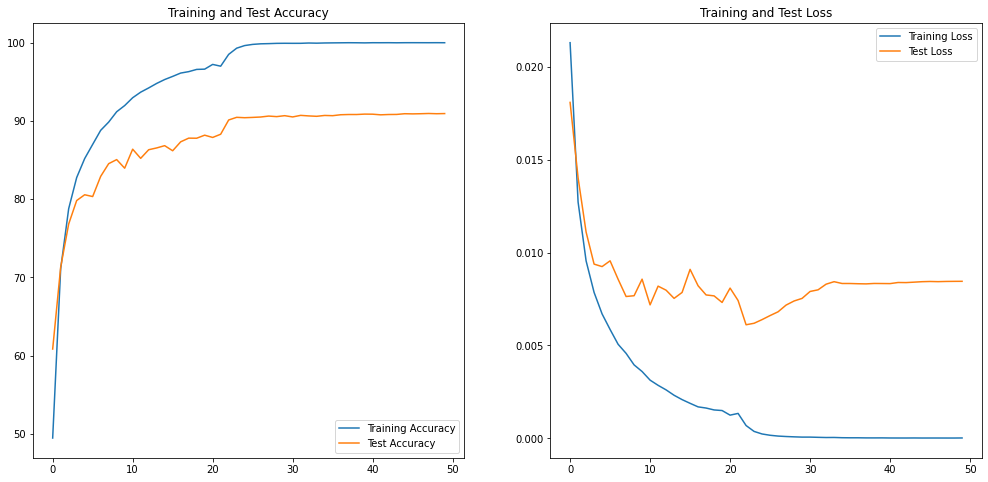

In [ ]:
plt.figure(figsize=(17, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), metrics['train_accuracy'], label='Training Accuracy')
plt.plot(range(epochs), metrics['test_accuracy'], label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), metrics['train_loss'], label='Training Loss')
plt.plot(range(epochs), metrics['test_loss'], label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Test Loss')
plt.show()